In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from dataloader import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2024-01-04 15:39:18.385060: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 15:39:18.387927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 15:39:18.450777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 15:39:19.989711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load data

In [2]:
ETTh1_data = pd.read_csv('data/ETTh1.csv', header=None).to_numpy()

In [3]:
ETTh1_data.shape

(17420, 7)

In [4]:
batch_size = 32
n_train = 8545
n_eval = 2881
n_test = 2881
train_loader, eval_loader, test_loader = get_loaders(ETTh1_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Modèle

In [5]:
class Embedding_inverted(nn.Module):
    def __init__(self, T, D):
        super(Embedding_inverted, self).__init__()
        self.emb = nn.Linear(T, D)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = x.permute(0,2,1)
        x_emb = self.emb(x)
        return self.dropout(x_emb)

class FeedForward(nn.Module):
    def __init__(self, D):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Linear(D, D),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(D, D), 
        )

    def forward(self, x):
        #x = x.permute(0,2,1)
        x = self.feed_forward(x)
        #x = x.permute(0,2,1)
        return x
    
class Attention(nn.Module):
    def __init__(self, D, proj_dim, nb_head=8):
        super(Attention, self).__init__()
        self.query_projection = nn.Linear(D, proj_dim)
        self.key_projection = nn.Linear(D, proj_dim)
        self.value_projection = nn.Linear(D, proj_dim)
        self.out_projection = nn.Linear(proj_dim, D)
        self.H = nb_head

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.H

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = 1. / torch.sqrt(torch.tensor(E))

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = torch.softmax(scale * scores, dim=-1)
        V = torch.einsum("bhls,bshd->blhd", A, values)

        out = V.reshape(B,L,-1)

        return self.out_projection(out)
        

class TrmBlock(nn.Module):
    def __init__(self, N, D, proj_dim):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= Attention(D, proj_dim)
      self.layer_norm1 = nn.LayerNorm(D)
      self.feed_forward = FeedForward(D)
      self.layer_norm2 = nn.LayerNorm(D)

    def forward(self, x):
      att = self.multivariate_attention(x,x,x)
      x = self.layer_norm1(x + att)
      #print("x_norm  : ", x.shape)
      #print("permute : ", xT.shape)
      x_forward = self.feed_forward(x)
      x= self.layer_norm2(x + x_forward)
      return x


class iTransformer(nn.Module):
    def __init__(self, N, T, D, S, proj_dim, num_blocks):
      super(iTransformer, self).__init__()

      self.embedding = Embedding_inverted(T, D)
      self.trmblock = nn.ModuleList([TrmBlock(N, D, proj_dim) for _ in range(num_blocks)])
      self.projection = nn.Linear(D, S, bias=True)


    def forward(self, x):
      #print("x : ",x.shape)
      x = self.embedding(x)
      #print('emb : ',x.shape)
      for block in self.trmblock:
            x = block(x)
      #print('trmblock : ',x.shape)
      y = self.projection(x)
      #print('proj : ', y.shape)
      y=y.permute(0,2,1)
      #print('final : ', y.shape)
      return y

## Train

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cpu


In [7]:
N = 7 #nb variables
T = 96 #input length (lookback window)
D = 512 # 256 ou 512
S = 96 # 96 ou 192, 336, 720
proj_dim = 128
#hidden_dim = 176 #dimension latente dans le feed forward du transformer 
num_blocks = 4 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, proj_dim, num_blocks)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-3) #10−3, 5 × 10−4, 10−4 



In [8]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device)

---- epoch :  0
loss train : 0.38582666866651927
loss eval : 0.4666390252463958
---- epoch :  1
loss train : 0.32945859523219917
loss eval : 0.4502683302935432
---- epoch :  2
loss train : 0.32307720286700564
loss eval : 0.4471016412272173
---- epoch :  3
loss train : 0.31856409130433133
loss eval : 0.4831898571813808
---- epoch :  4
loss train : 0.3134737567023467
loss eval : 0.48617999080349417
---- epoch :  5
loss train : 0.3243608976934702
loss eval : 0.4504988026969573
---- epoch :  6
loss train : 0.336303838962362
loss eval : 0.5375826660324545
---- epoch :  7
loss train : 0.3527576144187505
loss eval : 0.5021732067360597
---- epoch :  8
loss train : 0.3450608470740209
loss eval : 0.4548151163493886
---- epoch :  9
loss train : 0.3507352295040174
loss eval : 0.49446826331755694


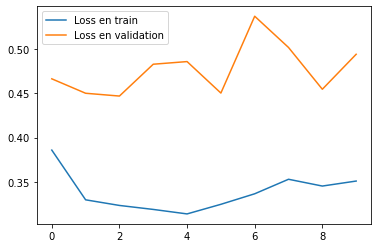

In [9]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

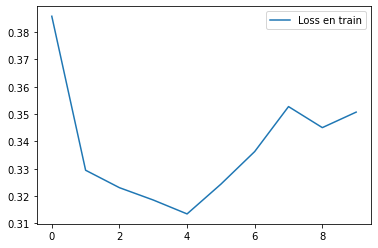

In [10]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.legend()
plt.show()

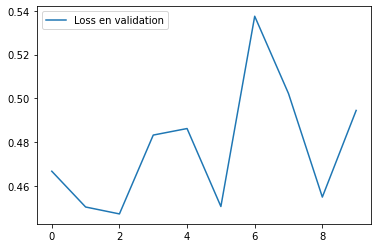

In [11]:
plt.figure()
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [12]:
loss_test, target, yhat = test(itransformer, test_loader, device)

print("MSE : ", loss_test)

MSE :  0.7813913702964783


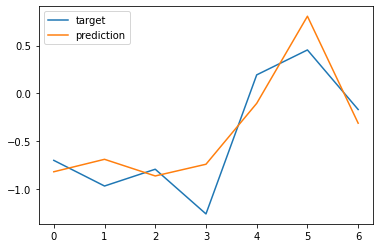

In [13]:
i = 0
plt.figure()
plt.plot(target[0][:][i].to("cpu"),label="target")
plt.plot(yhat[0][:][i].to("cpu"),label="prediction")
plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.plot(target[0][:][i][:100].to("cpu"),label="target")
plt.plot(yhat[0][:][i][:100].to("cpu"),label="prediction")
plt.legend()
plt.show()